# 2) Data Analysis and Modeling - Natural Language Processing on US Streaming Hit Lyrics

__The following Jupyter Notebook cleans, analyzes, and models the data collected in the previous portion of this project.__ This Notebook is to be split in the following portions:
- Imports
- Data Cleaning
- Removing Stopwords, Lemmatizing, and Adding Wordcount 
- WordCloud
- Word Frequency Analysis
- Sentiment Analysis

# Imports

In [1]:
#to allow interaction with underlying operating system
import os

#to work with Regular Expressions
import re

#for data analysis
import numpy as np
import pandas as pd

#for data visualization
import matplotlib.pyplot as plt

#to remove the limits on a dataframe's columns displayed
pd.set_option('display.max_columns', None)

#to access google sheets with python
import gspread
from google.oauth2 import service_account
from oauth2client.service_account import ServiceAccountCredentials

#to edit google sheets from python
from df2gspread import df2gspread as d2g

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#for word analysis
from langdetect import detect 
import nltk 
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

#to create a WordCloud
from wordcloud import WordCloud

#for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
#service account
sa = gspread.service_account(filename="gspread_service_account.json")

#sheet
sh = sa.open("HITS Streaming Songs")

#worksheet
wks = sh.worksheet("Top Songs' Lyrics")

#uses all values in the worksheet for the data frame
gsheets_df = pd.DataFrame(wks.get_all_values())

header = gsheets_df.iloc[0] #isolate first row as header
gsheets_df = gsheets_df[1:] #get rid of header in original df
gsheets_df.columns = header

#set 'index' as index
gsheets_df = gsheets_df.set_index('index')

#convert index from string to int
gsheets_df.index = gsheets_df.index.astype(int)
gsheets_df

,song,artist,lyrics
index,,,
0,It Ain't Me (Ft. Selena Gomez),Kygo & Selena Gomez,It Ain’t Me Lyrics[Verse 1: Selena Gomez]\nI h...
1,Shape of You,Ed Sheeran,Shape of You Lyrics[Verse 1]\nThe club isn't t...
2,Passionfruit,Drake,Passionfruit Lyrics[Intro: Moodymann]\nHold on...
3,Portland (Ft. Quavo & Travis Scott),Drake,Portland Lyrics[Intro: Drake & Baka Not Nice]\...
4,Gyalchester,Drake,Gyalchester Lyrics[Chorus: Drake & Baka Not Ni...
...,...,...,...
478,She Had Me At Heads Carolina,Cole Swindell,She Had Me At Heads Carolina Lyrics[Intro]\n(H...
479,Sunroof,Nicky Youre & Dazy,"Sunroof Lyrics[Intro]\nLa da la da da, la da d..."
480,I Ain't Worried,OneRepublic,I Ain’t Worried Lyrics[Verse 1]\nI don't know ...


# Data Cleaning
Before performing analysis on the lyrics, we need to clean the data collected.

In the next following cells, we remove all songs that are not in English (or where English is not the predominant language). Then we remove all text inside brackets and punctuations as well.

In [3]:
#Detecting Language [borrowed code from Ken Lee]
def language_detector(x):
    try:
        return detect(x)
    except:
        None 

#Removing the text in the brackets []
def remove_brackets(lyrics):
    return re.sub("[\(\[].*?[\)\]]", "", lyrics)

#Removing Punctuations
def remove_punctuations(lyrics):
    return  " ".join(re.findall("[a-zA-Z]+", lyrics))

In [4]:
#limit songs to English songs
gsheets_df['lang'] = gsheets_df['lyrics'].apply(lambda x:language_detector(x))
gsheets_df = gsheets_df[gsheets_df['lang'] == 'en']

#remove brakcets, puncuations, and lowercase the words
gsheets_df['lyrics'] = gsheets_df['lyrics'].apply(lambda x: remove_brackets(x))
gsheets_df['lyrics'] = gsheets_df['lyrics'].apply(lambda x: remove_punctuations(x))
gsheets_df['lyrics'] = gsheets_df['lyrics'].apply(lambda x: x.lower())

#reset index
gsheets_df.reset_index(drop=True,inplace=True)

#gets rid of "lyrics" at the beginning of the lyrics via splitting
gsheets_df['lyrics'] = gsheets_df['lyrics'].str.split("lyrics ")
for i in range(len(gsheets_df)):
    gsheets_df['lyrics'][i] = gsheets_df['lyrics'][i][1]

#getting rid of other unneccessary words
gsheets_df['lyrics'] = gsheets_df['lyrics'].str.replace('embed','')
gsheets_df['lyrics'] = gsheets_df['lyrics'].str.replace('kembed','')
gsheets_df['lyrics'] = gsheets_df['lyrics'].str.replace('related songs ','')
gsheets_df['lyrics'] = gsheets_df['lyrics'].str.strip(' ')

gsheets_df

,song,artist,lyrics,lang
0,It Ain't Me (Ft. Selena Gomez),Kygo & Selena Gomez,i had a dream we were sipping whiskey neat hig...,en
1,Shape of You,Ed Sheeran,the club isn t the best place to find a lover ...,en
2,Passionfruit,Drake,hold on hold on fuck that fuck that shit hold ...,en
3,Portland (Ft. Quavo & Travis Scott),Drake,murda on the beat so it s not nice yeah it s a...,en
4,Gyalchester,Drake,herm s link ice blue mink tat on my ribs like ...,en
...,...,...,...,...
457,She Had Me At Heads Carolina,Cole Swindell,i was out with the boys catchin up at a neon l...,en
458,Sunroof,Nicky Youre & Dazy,la da la da da la da da la da la da di da da l...,en
459,I Ain't Worried,OneRepublic,i don t know what you ve been told but time is...,en
460,Bad Habit,Steve Lacy,i wish i knew you wanted me i wish i knew i wi...,en


# Removing Stopwords, Lemmatizing, and Adding Wordcounts
Stopwords are words that are commonly used words that we want to ignore in our analysis. They typically provide no value to understanding what types of words are used in our lyrics (words such as "and", "should", "so", "if", "having", etc.). 

To remove stopwords, we start by importing the stopwords recorded in _nltk.corpus_. Then we add additional stopwords in the following steps. For this project, explicit words are removed. However, if you want to see how the addition of explicit language impacts our results run this code, removing the last several words in the _additional_stopwords_ dictionary in the following cell.

Lemmatizing involves sorting words by grouping together different variants of the same word (ex: "spoken", "speaking", and "spoke" are all under "speak"). 

In [5]:
#Setting stopwords
stop = set(stopwords.words("english"))

#adding additional stopwords
additional_stopwords = {'gon','na','ooh','u','gim','cause','til','wan','na','c','llate','v',
                       'ta','ha','ya','ly','em','l','ayy','woah','uh','nagin','woo','ho','us',
                       'se','os','bout','ayo','okay','huh','voo','outta','eh','pi','atas',
                       'yeah','oh','ah','nah','mm','mmm','fuck','ody','fuckin','doo','da','n',
                       'know','hey','want','tryna','give','go', 'goin','take','well','let',
                       'still','come','make','never','back','like','put','really','even','wh',
                       'somethin','oo','thinkin','lil','keep','way','need','around','thing',
                       'little','get','nigga','bitch','hoe','shit','fuck','pussy'}
stop.update(additional_stopwords)

In [6]:
#Mapping Part-Of-Speech tag to first character lemmatize() accepts
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.VERB)

#create lemmatizer
lemmatizer = WordNetLemmatizer()

In [7]:
#combines the previous functions created
def lemma(lyrics):
    #lemmatize!
    lyrics = [lemmatizer.lemmatize(x, get_wordnet_pos(x)) for x in nltk.word_tokenize(lyrics)]
    
    #remove stopwords
    lyrics = [x for x in lyrics if x not in stop]
    
    return ' '.join(lyrics)

In [8]:
#apply the lemma function
gsheets_df['lyrics'] = gsheets_df['lyrics'].apply(lambda x: lemma(x))

#get a wordcount of every song
gsheets_df['WordLength'] = np.array([len(lyrics) for lyrics in gsheets_df['lyrics']])

gsheets_df

,song,artist,lyrics,lang,WordLength
0,It Ain't Me (Ft. Selena Gomez),Kygo & Selena Gomez,dream sip whiskey neat high floor bowery high ...,en,782
1,Shape of You,Ed Sheeran,club best place find lover bar friend table sh...,en,1271
2,Passionfruit,Drake,hold hold hold start mothafuckin record wait m...,en,561
3,Portland (Ft. Quavo & Travis Scott),Drake,murda beat nice habibis ting side girl screen ...,en,1537
4,Gyalchester,Drake,herm link ice blue mink tat rib permanent wait...,en,648
...,...,...,...,...,...
457,She Had Me At Heads Carolina,Cole Swindell,boy catchin neon light walk karaoke night circ...,en,773
458,Sunroof,Nicky Youre & Dazy,la la la la la di la la la la la la di head su...,en,566
459,I Ain't Worried,OneRepublic,told time run slow step toe toe scar honey may...,en,462
460,Bad Habit,Steve Lacy,wish knew wish knew wish knew wish knew wish k...,en,678


# Wordcloud
Next, a wordcloud is to be created! Through this visualization, we can visualize what words are the most used in songs. First, we combine all the lyrics together. Then, we create the wordcloud itself through the following code:

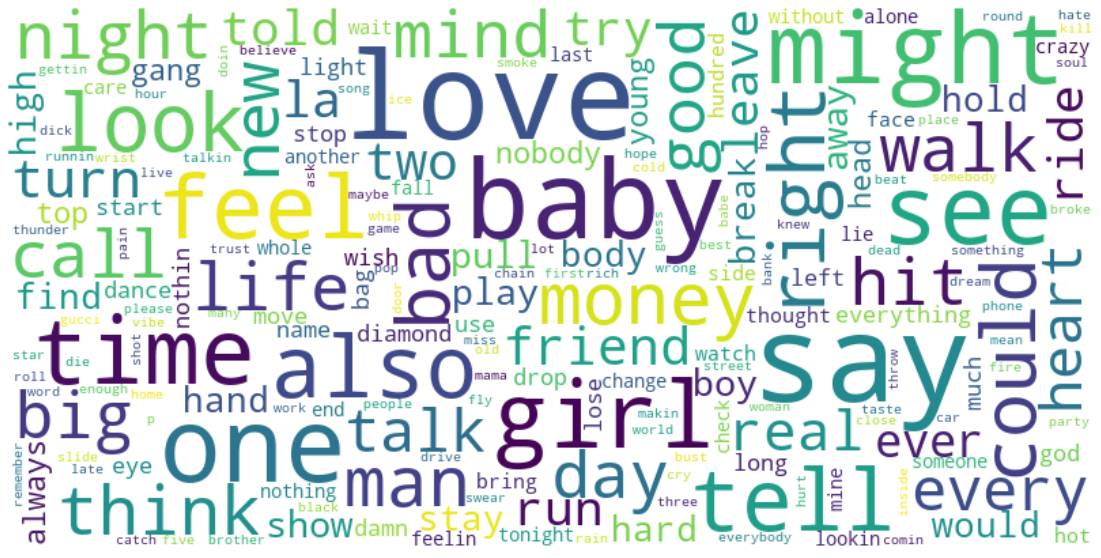

In [9]:
all_lyrics = " ".join(song_lyrics for song_lyrics in gsheets_df['lyrics'])
words = word_tokenize(all_lyrics)

word_cloud = WordCloud(background_color="white", max_font_size=90, 
    random_state=1, stopwords=stop, collocations=False,
    width=800, height=400).generate(all_lyrics)

plt.figure(figsize=(20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png',facecolor='k', bbox_inches='tight')

# Most Frequently Used Words
Excluding stopwords (and curse words), the most commonly used words used in hit song lyrics are the following:

In [10]:
fdist = FreqDist(words) #words is defined in the Wordcloud section
fdist.most_common(25) #the top ten most common words in hit songs since 2017

[('love', 997),
 ('say', 993),
 ('baby', 762),
 ('one', 694),
 ('might', 647),
 ('see', 585),
 ('time', 546),
 ('girl', 539),
 ('feel', 498),
 ('also', 463),
 ('tell', 463),
 ('look', 398),
 ('right', 373),
 ('could', 351),
 ('bad', 341),
 ('money', 331),
 ('man', 312),
 ('think', 303),
 ('call', 295),
 ('life', 293),
 ('walk', 290),
 ('night', 286),
 ('new', 284),
 ('day', 277),
 ('hit', 273)]

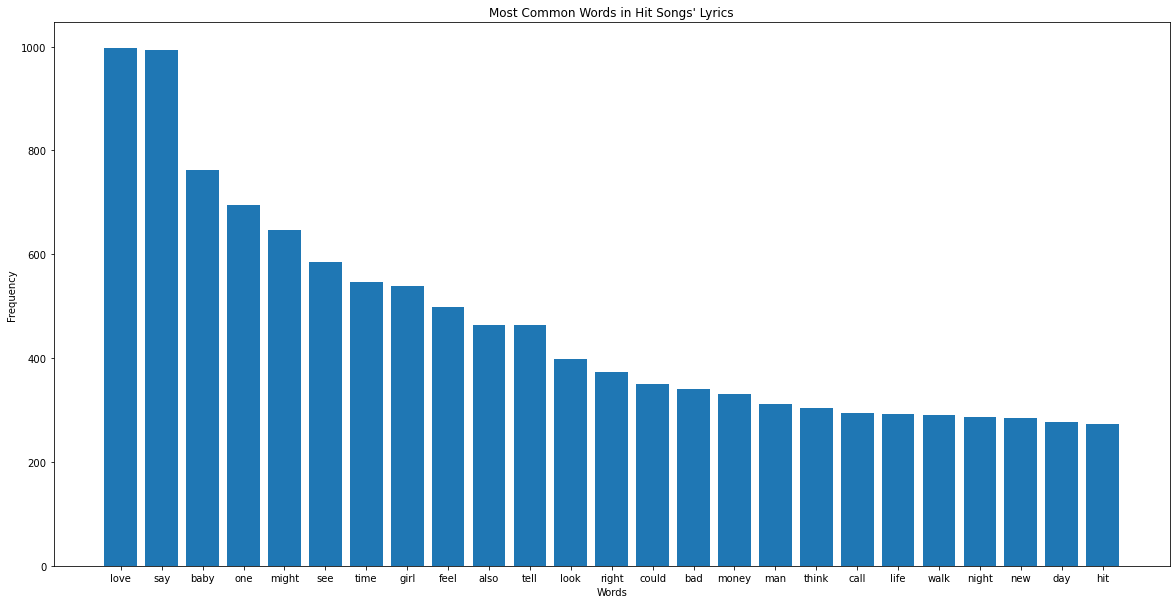

In [11]:
#Common Words Bar Graph
x , y = zip(*(fdist.most_common(25)))
plt.figure(figsize=(20, 10))
plt.bar(x, y)

plt.title("Most Common Words in Hit Songs' Lyrics")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

# Sentiment Analysis
The final portion of this project analyzes the lyrics for hit songs and determines the ratio of positive/negative words in the lyrics for hit songs. 

It is predicted for more words to possess negative qualities than positive qualities. However, the following analysis says otherwise (likely due to the fact that explicit words were deleted).

In [12]:
analyzer = SentimentIntensityAnalyzer()

#shows the sentiment for all combined lyrics
sentiment_dict = analyzer.polarity_scores(all_lyrics)
sentiment_dict

{'neg': 0.17, 'neu': 0.633, 'pos': 0.197, 'compound': 1.0}

In [13]:
#delete 'compound'
del sentiment_dict['compound']

<BarContainer object of 3 artists>

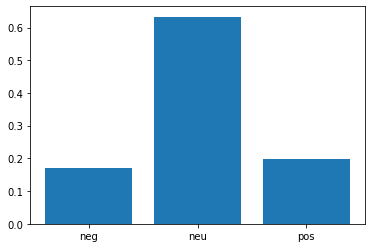

In [14]:
plt.bar(range(len(sentiment_dict)), list(sentiment_dict.values()),
        tick_label = list(sentiment_dict.keys()))

Contrary to expectations, when combining all lyrics together, positive words slightly outnumber negative words (once again likely due to the fact that curse words were omitted). To see whether this accounts for lyrics on the individual song level, we perform analysis: 

In [15]:
def individual_song_sentiment(song_lyrics):
    sentiment_dict = analyzer.polarity_scores(song_lyrics)
    return 'neg' if sentiment_dict['neg'] > sentiment_dict['pos'] else 'pos'

In [16]:
gsheets_df['song_sentiment'] = gsheets_df['lyrics'].apply(lambda song_lyrics: individual_song_sentiment(song_lyrics))
gsheets_df['song_sentiment'].value_counts()

pos    259
neg    203
Name: song_sentiment, dtype: int64

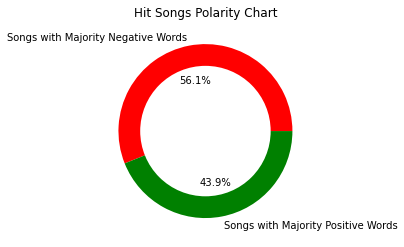

In [17]:
labels = ['Songs with Majority Negative Words','Songs with Majority Positive Words']
colors = ['red','green']

#creating pie plot
plt.pie(gsheets_df['song_sentiment'].value_counts(), autopct='%1.1f%%', labels = labels, colors = colors)

#inserting white hole in the middle
cc = plt.Circle((0,0),0.75,fc='white')
fig = plt.gcf()
fig.gca().add_artist(cc)

#adding label
plt.title("Hit Songs Polarity Chart")

plt.show()


# Conclusion
As seen in the charts above, when combining all song lyrics together, there are more positive lyrics than negative ones. However, on a song-by-song basis, there are more songs with majority negative words than majority positive words.

Although not shown in this final Notebook, amongst the most used words in song lyrics are curse words. These are typically associated with negativity. Therefore, adding them would likely skew the results to show even more negative sentiments than what is currently shown. 